In [1]:
# Imports 
import librosa
import librosa.display
import librosa.effects
import librosa.util

import numpy as np
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn import preprocessing
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
#Features we want right now: min f0, max f0, and mean f0 and maybe rms (not sure exactly what that is but was used in the paper)
path = '/home/CREMA-D/AudioWAV/'
files = os.listdir(path)

summary = pd.read_csv('/home/CREMA-D/processedResults/summaryTable.csv')

num_files = len(os.listdir(path)) #not sure how you want to count files
count = 0

# Aim to get to 12 features
num_features = 8

# Keep track of min and max duration of all data
min_dur = np.inf
max_dur = 0
max_length = 0

X = np.zeros((num_files, num_features))
Y = np.zeros(num_files).astype(str)
for sample in tqdm(files): #depends on how you access
    file = os.path.join(path,sample)
    current_wav, current_sr = librosa.load(file) #fix for set up 
    f0_series = librosa.yin(current_wav, librosa.note_to_hz('C2'), librosa.note_to_hz('C7'))
    rms_series = librosa.feature.rms(y=current_wav)
    f0_max = np.amax(f0_series)
    f0_min = np.amin(f0_series)
    # Get f0 range
    f0_range = f0_max - f0_min
    # duration
    duration = librosa.get_duration(y=current_wav, sr=current_sr)
    
    # Outer duration
    if duration > max_dur:
        max_dur = duration
    if duration < min_dur:
        min_dur = duration
        
    # Get the pitches
#     pitches, magnitudes = librosa.piptrack(y=current_wav, sr=current_sr)
#     pitch_max = np.amax(pitches)
#     pitch_min = np.amin(pitches)
#     # Get f0 range
#     pitch_range = pitch_max - pitch_min
#     pitch_mean = np.mean(pitches)
    
    f0_mean = np.mean(f0_series)
    rms_max = np.amax(rms_series)
    rms_min = np.amin(rms_series)
    rms_mean = np.mean(rms_series)
#     x = np.array([f0_min, f0_max, f0_mean, f0_range, duration, rms_min, rms_max, rms_mean, pitch_max, pitch_min, 
#                   pitch_range, pitch_mean])
    x = np.array([f0_min, f0_max, f0_mean, f0_range, duration, rms_min, rms_max, rms_mean])
    X[count,:] = x
    # Get the label for VoiceVote
    info = summary.loc[summary['FileName'] == sample.split('.')[0]]
    try:
        Y[count] = info['VoiceVote'].values[0]
    except Exception as ex:
        print(f'info: {info}')
        print(f'index count: {count}')
        index = count
        print(f'unable to find file: {sample}')
        count -= 1
    count += 1
print(f'shape of train data: {X.shape}')
print(f'shape of labels: {Y.shape}')

 39%|███▉      | 2914/7442 [04:48<08:00,  9.42it/s]

info: Empty DataFrame
Columns: [Unnamed: 0, FileName, VoiceVote, VoiceLevel, FaceVote, FaceLevel, MultiModalVote, MultiModalLevel]
Index: []
index count: 2912
unable to find file: 1040_ITH_SAD_X.wav


100%|██████████| 7442/7442 [12:07<00:00, 10.23it/s]

shape of train data: (7442, 8)
shape of labels: (7442,)


In [3]:
#For Logistic Regression, can use sklearn.linear_model.LogisticRegression
# !pip install -U scikit-learn
# import sklearn
# from sklearn.linear_model import LogisticRegression
# Remove the file that wasn't in results
print(f'shape of train data: {X.shape}')
print(f'shape of labels: {Y.shape}')
print(Y[7440:])

# Remove that one example without a label
X = np.delete(X,-1,axis=0)
Y = Y[:-1]
print(f'New X shape: {X.shape}')
print(f'New Y shape: {Y.shape}')
print(f'Example feature: {X[4,:]}')
print(f'Last Y to check: {Y[-1]}')
print(f'min duration: {min_dur}')
print(f'max duration: {max_dur}')

# Find number of unique labels
num_unique = np.unique(Y).shape[0]
print(f'num classes: {num_unique}')

# Use label encoder for string labels
le = preprocessing.LabelEncoder()
le.fit(Y)
print(f'classes: {le.classes_}')
transformed_labels = le.transform(Y)
print(f'shape of transformed labels: {transformed_labels.shape}')

shape of train data: (7442, 8)
shape of labels: (7442,)
['N' '0.0']
New X shape: (7441, 8)
New Y shape: (7441,)
Example feature: [7.25388728e+01 2.79622457e+02 1.54880632e+02 2.07083584e+02
 2.70272109e+00 4.40623751e-03 5.49128167e-02 1.39149548e-02]
Last Y to check: N
min duration: 1.2679818594104308
max duration: 5.005034013605442
num classes: 39
classes: ['A' 'A:D' 'A:D:F:N' 'A:D:F:N:S' 'A:D:H:N' 'A:D:N' 'A:D:N:S' 'A:F' 'A:F:N'
 'A:H' 'A:H:N' 'A:N' 'A:N:S' 'A:S' 'D' 'D:F' 'D:F:H:N' 'D:F:N' 'D:F:N:S'
 'D:F:S' 'D:H' 'D:H:N' 'D:N' 'D:N:S' 'D:S' 'F' 'F:H' 'F:H:N' 'F:H:N:S'
 'F:N' 'F:N:S' 'F:S' 'H' 'H:N' 'H:N:S' 'H:S' 'N' 'N:S' 'S']
shape of transformed labels: (7441,)


In [4]:
# Create dataset from the data
class CREMADataset(Dataset):
    """
    CREMA-D dataset to load and use
    """
    def __init__(self, X, Y, num_examples, split='train', train_ratio = 0.8, val_ratio = 0.1):
        super().__init__()
        # X are the features, Y are the labels
        self.Y = Y  
        self.X = X
        self.num_examples = num_examples
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio

        # Decides which indices belong to which split.
        train_indices, val_indices, test_indices = self.split_data(num_examples, train_ratio=train_ratio, val_ratio=val_ratio)

        if split == 'train':
            indices = train_indices
        elif split == 'val':
            indices = val_indices
        elif split == 'test':
            indices = test_indices
        else:
            raise Exception(f'Split {split} not supported.')
            
        self.indices = indices

    def split_data(self, num_examples, train_ratio = 0.8, val_ratio = 0.1):
        """Splits data into train, val, and test sets based on speaker. When 
        evaluating methods on the test split, we measure how well they generalize
        to new (unseen) speakers.

        Concretely, this stores and returns indices belonging to each split.
        """
        # Fix seed so everyone reproduces the same splits.
        rs = np.random.RandomState(42)

        indices = np.arange(0, num_examples)
        train_idx = int(num_examples * train_ratio)
        num_remaining = num_examples - train_idx
        val_idx = train_idx + int(num_remaining/2)
        
        print(f'train idx: {train_idx}')
        print(f'val idx: {val_idx}')
        
        train_indices = indices[:train_idx]
        val_indices = indices[train_idx:val_idx]
        test_indices = indices[val_idx:]
        return train_indices, val_indices, test_indices

    def __getitem__(self, index):
        index = self.indices[index]
        return torch.FloatTensor(self.X[index,:]), torch.LongTensor([self.Y[index]])

    def __len__(self):
        """Returns total number of utterances in the dataset."""
        return len(self.indices)


In [5]:
# Define the transformer
class MLP(nn.Module):
    def __init__(self, input_dim, n_classes):
        super().__init__()
        # Initialize layers
        self.linear = nn.Linear(input_dim, n_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        output = self.linear(x)
        result = self.relu(output)
        return result
    
class EmotionTransformerPrototype(nn.Module):
    def __init__(self, input_dim, num_class, num_layers=2, hidden_dim=128):
        super().__init__()
        # Note: `batch_first=True` argument implies the inputs to the LSTM should
        # be of shape (batch_size x T x D) instead of (T x batch_size x D).
        self.encoder = MLP(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, num_class)
        self.input_dim = input_dim
        self.num_class = num_class
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
    def forward(self, inputs):
        log_probs = None
        # Hint: This is an N-way classification problem.
        embed = self.encoder(inputs)
        output = self.decoder(embed)
        # Softmax for N-way classification, followed by log to make them log_probs
        # log_probs = F.log_softmax(output, dim=2)
        log_probs = F.log_softmax(output, dim=-1)
        # If log softmax --> use negative log likelihood loss
        # If normal probabilities --> use normal cross entropy (equivalent methods!)
        return log_probs
  
    def get_loss(self, probs, targets):
        loss = None
        # Cross entropy loss if probs is normal probabilities
        # Negative log likelihood if probs is log probs
        # probs = probs.view(-1)
        # targets = targets.view(-1).type(dtype=torch.float) # --> float()
        # loss = F.cross_entropy(probs, targets)
        loss = F.nll_loss(probs, targets)
        return loss

class EmotionCNNTransformer(nn.Module):
    def __init__(
          self, input_dim, num_class, kernel_size, num_layers=2, hidden_dim=128, stride=1, padding=0):
        super().__init__()
        # Note: `batch_first=True` argument implies the inputs to the LSTM should
        # be of shape (batch_size x T x D) instead of (T x batch_size x D).
        self.encoder = nn.Conv1d(input_dim, hidden_dim, kernel_size, stride=stride, padding=padding)
        self.decoder = nn.Linear(hidden_dim, num_class)
        self.input_dim = input_dim
        self.num_class = num_class
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

    
class EmotionRNNTransformer(nn.Module):
    """
  Encoder-Decoder model to classify emotions for utterances.

  Args:
    input_dim: integer
                number of input features
    num_class: integer
                number of class labels
    num_layers: integer (default: 2)
                number of layers in encoder LSTM
    hidden_dim: integer (default: 128)
                number of hidden dimensions for encoder LSTM
    bidirectional: boolean (default: True)
                    is the encoder LSTM bidirectional?
  """
    def __init__(
          self, input_dim, num_class, num_layers=2, hidden_dim=128,
          bidirectional=True):
        super().__init__()
        # Note: `batch_first=True` argument implies the inputs to the LSTM should
        # be of shape (batch_size x T x D) instead of (T x batch_size x D).
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                                bidirectional=bidirectional, batch_first=True)
        self.decoder = nn.Linear(hidden_dim * 2, num_class)
        self.input_dim = input_dim
        self.num_class = num_class
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = hidden_dim * num_layers * 2 * \
                              (2 if bidirectional else 1)

    def combine_h_and_c(self, h, c):
        """Combine the signals from RNN hidden and cell states."""
        batch_size = h.size(1)
        h = h.permute(1, 0, 2).contiguous()
        c = c.permute(1, 0, 2).contiguous()
        h = h.view(batch_size, -1)
        c = c.view(batch_size, -1)
        return torch.cat([h, c], dim=1)  # just concatenate

    def forward(self, inputs, input_lengths):
        batch_size, max_length, _ = inputs.size()
        # `torch.nn.utils.rnn.pack_padded_sequence` collapses padded sequences
        # to a contiguous chunk
        inputs = torch.nn.utils.rnn.pack_padded_sequence(
            inputs, input_lengths.cpu(), batch_first=True, enforce_sorted=False)
        log_probs = None
        h, c = None, None
        ############################ START OF YOUR CODE ############################
        # TODO(2.1)
        # Hint:
        # - Refer to https://pytorch.org/docs/stable/nn.html
        # - Use `self.encoder` to get the encodings output which is of shape
        #   (batch_size, max_length, num_directions*hidden_dim) and the
        #   hidden states and cell states which are both of shape
        #   (batch_size, num_layers*num_directions, hidden_dim)
        # - Pad outputs with `0.` using `torch.nn.utils.rnn.pad_packed_sequence`
        #   (turn on batch_first and set total_length as max_length).
        # - Apply 50% dropout.
        # - Use `self.decoder` to take the embeddings sequence and return
        #   probabilities for each character.
        # - Make sure to then convert to log probabilities.

        # Get encodings
        encodings, (h, c) = self.encoder(inputs)

        # Pad outputs with '0'
        padded, lengths = torch.nn.utils.rnn.pad_packed_sequence(encodings, batch_first=True, total_length=max_length)

        # Apply dropout
        dropout = nn.Dropout(p=0.5)
        dropped_padded = dropout(padded)

        # Decode to get probabilies dimensions (batch_size, time steps, num chars <vocab>)
        probabilities = self.decoder(dropped_padded)

        # Log probabilities
        # dim=2 because softmax over the vocabulary dimension. dim=1 is over time steps
        log_probs = F.log_softmax(probabilities, dim=2)

        ############################# END OF YOUR CODE #############################

        # The extracted embedding is not used for the ASR task but will be
        # needed for other auxiliary tasks.
        embedding = self.combine_h_and_c(h, c)
        return log_probs, embedding

    def get_loss(self, log_probs, targets):
            # cross-entropy for softmax/negative log likelihood loss for log softmax
        return F.nll_loss(probs, targets)

    def decode(self, log_probs, input_lengths, labels, label_lengths):
        # Use greedy decoding.
        decoded = torch.argmax(log_probs, dim=2)
        batch_size = decoded.size(0)

        hypothesis_lengths = input_lengths.cpu().numpy().tolist()
        if labels is None: # Run at inference time.
          references, reference_lengths = None, None
        else:
          references = labels.cpu().numpy().tolist()
          reference_lengths = label_lengths.cpu().numpy().tolist()

        return hypotheses, hypothesis_lengths, references, reference_lengths

In [6]:
# Set up the dataloaders
train_dataset = CREMADataset(X, transformed_labels, X.shape[0], split='train')
val_dataset = CREMADataset(X, transformed_labels, X.shape[0], split='val')
test_dataset = CREMADataset(X, transformed_labels, X.shape[0], split='test')

# Check dataset length
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

# Check data
print(train_dataset[0])
print(test_dataset[0])

# Set dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train idx: 5952
val idx: 6696
train idx: 5952
val idx: 6696
train idx: 5952
val idx: 6696
5952
744
745
(tensor([6.8573e+01, 2.7087e+02, 1.8743e+02, 2.0229e+02, 2.1688e+00, 3.4345e-03,
        1.8924e-02, 8.0639e-03]), tensor([36]))
(tensor([6.8139e+01, 7.0053e+02, 2.0496e+02, 6.3239e+02, 2.8029e+00, 3.7657e-03,
        8.5794e-02, 2.4723e-02]), tensor([36]))


  3%|▎         | 1/30 [00:01<00:30,  1.05s/it]

Epoch 0 - Training loss: 14.444 , Training Accuracy: 0.381
Epoch 0 - Validation loss: 14.848 , Validation Accuracy: 0.265


  7%|▋         | 2/30 [00:02<00:28,  1.02s/it]

Epoch 1 - Training loss: 8.361 , Training Accuracy: 0.812


 10%|█         | 3/30 [00:03<00:27,  1.01s/it]

Epoch 2 - Training loss: 7.587 , Training Accuracy: 1.248


 13%|█▎        | 4/30 [00:04<00:25,  1.00it/s]

Epoch 3 - Training loss: 6.760 , Training Accuracy: 1.688


 17%|█▋        | 5/30 [00:05<00:24,  1.00it/s]

Epoch 4 - Training loss: 6.192 , Training Accuracy: 2.132


 20%|██        | 6/30 [00:06<00:24,  1.02s/it]

Epoch 5 - Training loss: 5.869 , Training Accuracy: 2.575
Epoch 5 - Validation loss: 4.322 , Validation Accuracy: 0.536


 23%|██▎       | 7/30 [00:07<00:23,  1.01s/it]

Epoch 6 - Training loss: 4.884 , Training Accuracy: 3.042


 27%|██▋       | 8/30 [00:08<00:21,  1.00it/s]

Epoch 7 - Training loss: 5.200 , Training Accuracy: 3.509


 30%|███       | 9/30 [00:09<00:20,  1.01it/s]

Epoch 8 - Training loss: 4.918 , Training Accuracy: 3.968


 33%|███▎      | 10/30 [00:10<00:19,  1.01it/s]

Epoch 9 - Training loss: 4.711 , Training Accuracy: 4.439


 37%|███▋      | 11/30 [00:11<00:19,  1.04s/it]

Epoch 10 - Training loss: 4.612 , Training Accuracy: 4.906
Epoch 10 - Validation loss: 3.597 , Validation Accuracy: 0.497


 40%|████      | 12/30 [00:12<00:19,  1.10s/it]

Epoch 11 - Training loss: 3.960 , Training Accuracy: 5.389


 43%|████▎     | 13/30 [00:13<00:18,  1.07s/it]

Epoch 12 - Training loss: 3.899 , Training Accuracy: 5.875


 47%|████▋     | 14/30 [00:14<00:16,  1.05s/it]

Epoch 13 - Training loss: 3.591 , Training Accuracy: 6.357


 50%|█████     | 15/30 [00:15<00:15,  1.03s/it]

Epoch 14 - Training loss: 3.570 , Training Accuracy: 6.834


 53%|█████▎    | 16/30 [00:16<00:14,  1.03s/it]

Epoch 15 - Training loss: 3.285 , Training Accuracy: 7.325
Epoch 15 - Validation loss: 2.323 , Validation Accuracy: 0.519


 57%|█████▋    | 17/30 [00:17<00:13,  1.02s/it]

Epoch 16 - Training loss: 3.378 , Training Accuracy: 7.807


 60%|██████    | 18/30 [00:18<00:12,  1.01s/it]

Epoch 17 - Training loss: 3.083 , Training Accuracy: 8.307


 63%|██████▎   | 19/30 [00:19<00:11,  1.00s/it]

Epoch 18 - Training loss: 2.980 , Training Accuracy: 8.806


 67%|██████▋   | 20/30 [00:20<00:10,  1.00s/it]

Epoch 19 - Training loss: 2.574 , Training Accuracy: 9.317


 70%|███████   | 21/30 [00:21<00:09,  1.02s/it]

Epoch 20 - Training loss: 2.819 , Training Accuracy: 9.810
Epoch 20 - Validation loss: 3.178 , Validation Accuracy: 0.507


 73%|███████▎  | 22/30 [00:22<00:08,  1.01s/it]

Epoch 21 - Training loss: 2.466 , Training Accuracy: 10.317


 77%|███████▋  | 23/30 [00:23<00:07,  1.01s/it]

Epoch 22 - Training loss: 2.595 , Training Accuracy: 10.818


 80%|████████  | 24/30 [00:24<00:06,  1.00s/it]

Epoch 23 - Training loss: 2.489 , Training Accuracy: 11.322


 83%|████████▎ | 25/30 [00:25<00:05,  1.00s/it]

Epoch 24 - Training loss: 2.243 , Training Accuracy: 11.838


 87%|████████▋ | 26/30 [00:26<00:04,  1.01s/it]

Epoch 25 - Training loss: 2.177 , Training Accuracy: 12.354
Epoch 25 - Validation loss: 1.892 , Validation Accuracy: 0.516


 90%|█████████ | 27/30 [00:27<00:03,  1.01s/it]

Epoch 26 - Training loss: 2.196 , Training Accuracy: 12.865


 93%|█████████▎| 28/30 [00:28<00:01,  1.00it/s]

Epoch 27 - Training loss: 2.054 , Training Accuracy: 13.392


 97%|█████████▋| 29/30 [00:29<00:00,  1.01it/s]

Epoch 28 - Training loss: 1.987 , Training Accuracy: 13.920


100%|██████████| 30/30 [00:30<00:00,  1.01s/it]

Epoch 29 - Training loss: 1.982 , Training Accuracy: 14.450


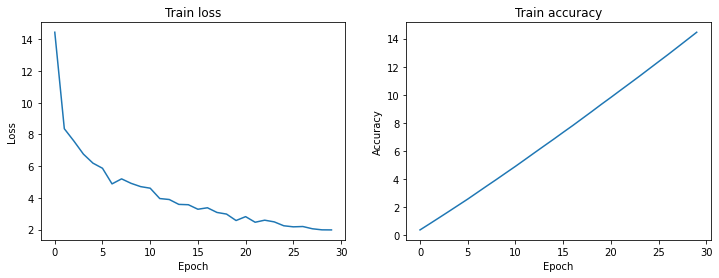

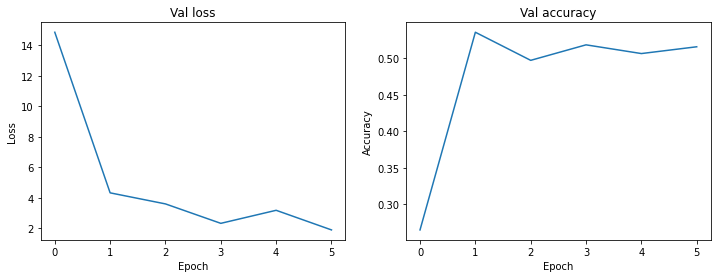

In [11]:
# Set up the model
model = EmotionTransformerPrototype(num_features, num_unique).cuda()
criterion = nn.NLLLoss()
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# start training
losses = []
val_loss = []
accuracies = []
val_accuracy = []
correct_count = 0

epochs = 30
for epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0
    for x,y in train_loader:
        optim.zero_grad()
        
        x_cuda = x.cuda()
        y_cuda = torch.squeeze(y).cuda()
        
        # Output from mode
        output = model(x_cuda)
        output = output.cuda()
        
        # Calculate loss
        loss = criterion(output, y_cuda)
        
        # Calculate predictions
        # Need to take max over the log probs (batch_size, num_classes)
        _, pred = torch.max(output, 1)
        pred = pred.type(torch.FloatTensor).cuda()
        
        num_correct = np.sum(y_cuda.cpu().detach().numpy() == pred.cpu().detach().numpy())
        correct_count += num_correct
        
        # Backprop
        loss.backward()
        
        # Update weights
        optim.step()
        
        # Keep track of losses
        running_loss += loss.item()
    # Calculate average loss
    epoch_loss = running_loss / len(train_loader)
    
    # Accuracy
    accuracy = correct_count / (len(train_loader) * batch_size)
    
    losses.append(epoch_loss)
    accuracies.append(accuracy)
    print("Epoch %d - Training loss: %.3f , Training Accuracy: %.3f" %
          (epoch, epoch_loss, accuracy))
    
    # Validation every 10 epochs
    if epoch % 5 == 0:
        model.eval()
        correct_eval = 0
        eval_loss = 0
        for x,y in val_loader:
            x_cuda = x.cuda()
            y_cuda = torch.squeeze(y).cuda()
            
            # Output from mode
            output = model(x_cuda)
            output = output.cuda()
            # Loss
            loss = criterion(output, y_cuda)
            
            # Need to take max over the log probs (batch_size, num_classes)
            _, pred = torch.max(output, 1)
            pred = pred.type(torch.FloatTensor).cuda()
        
            num_correct = np.sum(y_cuda.cpu().detach().numpy() == pred.cpu().detach().numpy())
            correct_eval += num_correct
            eval_loss += loss.item()
        # Calculate average loss
        epoch_loss = eval_loss / len(val_loader)
        val_loss.append(epoch_loss)
    
        # Accuracy
        accuracy = correct_eval / (len(val_loader) * batch_size)
        val_accuracy.append(accuracy)
        print("Epoch %d - Validation loss: %.3f , Validation Accuracy: %.3f" %
          (epoch, epoch_loss, accuracy))

# Train plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(losses)
ax2.plot(accuracies)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax1.set_title('Train loss')
ax2.set_title('Train accuracy')
plt.show()

# Val plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(val_loss)
ax2.plot(val_accuracy)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax1.set_title('Val loss')
ax2.set_title('Val accuracy')
plt.show()

In [14]:
# Run testing on the results
model.eval()
correct_test = 0
test_loss = 0
total_macro = 0
total_micro = 0
for x,y in test_loader:
    x_cuda = x.cuda()
    y_cuda = torch.squeeze(y).cuda()

    # Output from mode
    output = model(x_cuda)
    output = output.cuda()
    
    # Loss
    loss = criterion(output, y_cuda)

    # Need to take max over the log probs (batch_size, num_classes)
    _, pred = torch.max(output, 1)
    pred = pred.type(torch.FloatTensor).cuda()

    num_correct = np.sum(y_cuda.cpu().detach().numpy() == pred.cpu().detach().numpy())
    
    f1 = f1_score(y_cuda.cpu().detach().numpy(), pred.cpu().detach().numpy(), average='macro')
    total_macro += f1
    f1 = f1_score(y_cuda.cpu().detach().numpy(), pred.cpu().detach().numpy(), average='micro')
    total_micro += f1
    
    correct_test += num_correct
    test_loss += loss
# Calculate average loss
epoch_loss = test_loss / len(test_loader)

# Accuracy
accuracy = correct_test / (len(test_loader) * batch_size)
avg_macro = total_macro / len(test_loader)
avg_micro = total_micro / len(test_loader)
print("Test loss: %.3f , Test Accuracy: %.3f, Avg F1 macro: %.4f, Avg F1 micro: %.3f" % 
      (epoch_loss, accuracy, avg_macro, avg_micro))

Test loss: 1.755 , Test Accuracy: 0.556, Avg F1 macro: 0.2334, Avg F1 micro: 0.560


In [9]:
# Get data and labels for training
# train_split = int(0.8 * num_files)
# print('train_split: ', train_split)
# print(f'train size: {X[:train_split].shape}, val size: {X[train_split:].shape}')

# model = LogisticRegression().fit(X[:train_split], Y[:train_split])

# # Predict on validation/test (80-20 split)
# predictions = model.predict(X[train_split:])

# # Output score (mean accuracy)
# score = model.score(X[train_split:],Y[train_split:])
# print(f'Test accuracy score: {score}')

# f1 = f1_score(Y[train_split:], predictions, average='macro')
# print(f'macro f1 score: {f1}')
# f1 = f1_score(Y[train_split:], predictions, average='micro')
# print(f'micro f1 score: {f1}')

In [10]:
# Some basic stats for the dataset
# avg = np.mean(X, axis=0)
# print(f'avg shape: {avg.shape}')
# stats = ['f0_min', 'f0_max', 'f0_mean', 'f0_range', 'duration', 'rms_min', 'rms_max', 'rms_mean', 'pitch_max', 'pitch_min', 
#                   'pitch_range', 'pitch_mean']
# stats = ['f0_min', 'f0_max', 'f0_mean', 'f0_range', 'duration', 'rms_min', 'rms_max', 'rms_mean']
# for j,stat in enumerate(stats):
#     print(f'{stat} average: {avg[j]}')